# Demo of iterator on BACMMAN images (real dataset)

In [12]:
# !pip install git+https://github.com/jeanollion/dataset_iterator.git
import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os

from google.colab import drive
ROOT = '/content/drive'     # default for the drive

drive.mount(ROOT, force_remount=True)

dataset_dir = f"{ROOT}/My Drive/BACMMAN_DISTNET/data/BACMMAN/"
dataset_path = os.path.join(dataset_dir, "train_val_eval.h5")
os.chdir(dataset_dir)

print(dataset_path)

Mounted at /content/drive
/content/drive/My Drive/BACMMAN_DISTNET/data/BACMMAN/train_val_eval.h5


## Load data

In [53]:
from dataset_iterator import MultiChannelIterator, PreProcessingImageGenerator
image_scaling = PreProcessingImageGenerator(lambda im:im/(2**16 - 1)) # simple scaling of 8-bit images -> data in [0, 1]

iterator = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "train", # change this for "eval" to get only evaluation dataset
                                input_channels=[0],
                                output_channels=[0], 
                                image_data_generators=[image_scaling],
                                batch_size=64
                                )

print(f"Number of batches {len(iterator)} of size {len(iterator[0][0])}")

Number of batches 155 of size 64


In [62]:
def plot_images(batch_x, batch_y=None, n=3):
    bx = np.squeeze(batch_x, -1)
    if batch_y is not None:
        by = np.squeeze(batch_y, -1)
    plt.figure(figsize=(n*2, 6))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(np.clip(bx[i], 0, 1))
        plt.title(label='X')
        plt.axis("off")
        if batch_y is not None:
            plt.subplot(2, n, n+i+1)
            plt.imshow(np.clip(by[i], 0, 1))
            plt.title(label='Y')
            plt.axis("off")

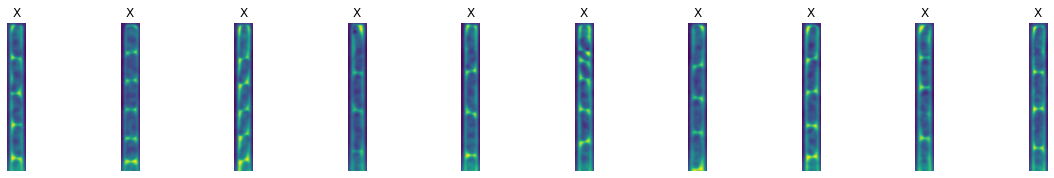

In [54]:
batch_x, batch_y = iterator[0]

plot_images(batch_x, None, n=10)

## Add data augmentation

In [60]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

corruption_function = lambda im : im + np.random.normal(0, 100, im.shape) # define here a corruption function that input a singla image and return and image of same shape

data_gen_in = ImageDataGenerator(vertical_flip=True,
                                 height_shift_range=0.5,
                                 rescale=1./(2**16 - 1), # to have values in range [0, 1]
                                 fill_mode="nearest",
                                 preprocessing_function=corruption_function)

data_gen_out = ImageDataGenerator(rescale = 1./(2**16 - 1),
                                  fill_mode="nearest",
                                  ) # no need to define geometrical transformations in this generator, as those of data_gen_in will automatically be applied, using the current fill_mode

iterator = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw", "/raw"], # for clarity we open here twice the images as they will be processed differently. one can also set None instead of the second keyword (as a placeholder) and define the corruption process in the channel_postprocessing_function argument.
                                group_keyword = "train", # change this for "eval" to get only evaluation dataset
                                input_channels=[0],
                                output_channels=[1], 
                                image_data_generators=[data_gen_in, data_gen_out], # one data generator for each channel (as defined in channel_keywords). Geometrical transformations will be identical
                                batch_size=64
                                )

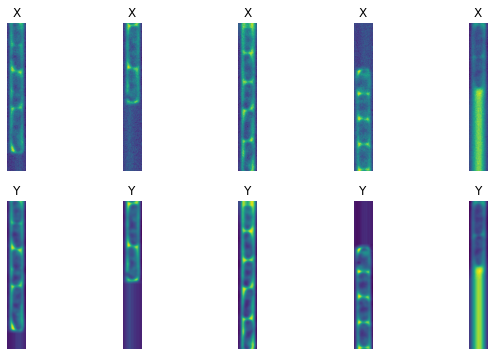

In [61]:
batch_x, batch_y = iterator[0]

plot_images(batch_x,  batch_y, n=5)